202101544 마영준

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torch.utils.data as data
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

In [21]:
batch_size= 1
learning_rate = 0.0002
num_epoch = 100

In [22]:
img_dir = "./images"
img_data = dset.ImageFolder(img_dir, transforms.Compose([
                                      transforms.Resize(256),                   
                                      transforms.RandomResizedCrop(224),        
                                      transforms.RandomHorizontalFlip(),        
                                      transforms.ToTensor(),                    
            ]))

train_loader = data.DataLoader(img_data, batch_size=batch_size,
                            shuffle=True, num_workers=2)

In [23]:
# ResNet 사용
def conv_block_1(in_dim,out_dim,act_fn,stride=1):
    model = nn.Sequential(
        nn.Conv2d(in_dim,out_dim, kernel_size=1, stride=stride),
        act_fn,
    )
    return model


def conv_block_3(in_dim,out_dim,act_fn):
    model = nn.Sequential(
        nn.Conv2d(in_dim,out_dim, kernel_size=3, stride=1, padding=1),
        act_fn,
    )
    return model

In [24]:
class BottleNeck(nn.Module):
    def __init__(self,in_dim,mid_dim,out_dim,act_fn,down=False):
        super(BottleNeck,self).__init__()
        self.down=down
        
        # 특성지도의 크기가 감소하는 경우
        if self.down:
            self.layer = nn.Sequential(
              conv_block_1(in_dim,mid_dim,act_fn,2),
              conv_block_3(mid_dim,mid_dim,act_fn),
              conv_block_1(mid_dim,out_dim,act_fn),
            )
            self.downsample = nn.Conv2d(in_dim,out_dim,1,2)
            
        # 특성지도의 크기가 그대로인 경우
        else:
            self.layer = nn.Sequential(
                conv_block_1(in_dim,mid_dim,act_fn),
                conv_block_3(mid_dim,mid_dim,act_fn),
                conv_block_1(mid_dim,out_dim,act_fn),
            )
            
        # 더하기를 위해 차원을 맞춰주는 부분
        self.dim_equalizer = nn.Conv2d(in_dim,out_dim,kernel_size=1)
                  
    def forward(self,x):
        if self.down:
            downsample = self.downsample(x)
            out = self.layer(x)
            out = out + downsample
        else:
            out = self.layer(x)
            if x.size() is not out.size():
                x = self.dim_equalizer(x)
            out = out + x
        return out


In [25]:
class ResNet(nn.Module):

    def __init__(self, base_dim, num_classes=2):
        super(ResNet, self).__init__()
        self.act_fn = nn.ReLU()
        self.layer_1 = nn.Sequential(
            nn.Conv2d(3,base_dim,7,2,3),
            nn.ReLU(),
            nn.MaxPool2d(3,2,1),
        )
        self.layer_2 = nn.Sequential(
            BottleNeck(base_dim,base_dim,base_dim*4,self.act_fn),
            BottleNeck(base_dim*4,base_dim,base_dim*4,self.act_fn),
            BottleNeck(base_dim*4,base_dim,base_dim*4,self.act_fn,down=True),
        )   
        self.layer_3 = nn.Sequential(
            BottleNeck(base_dim*4,base_dim*2,base_dim*8,self.act_fn),
            BottleNeck(base_dim*8,base_dim*2,base_dim*8,self.act_fn),
            BottleNeck(base_dim*8,base_dim*2,base_dim*8,self.act_fn),
            BottleNeck(base_dim*8,base_dim*2,base_dim*8,self.act_fn,down=True),
        )
        self.layer_4 = nn.Sequential(
            BottleNeck(base_dim*8,base_dim*4,base_dim*16,self.act_fn),
            BottleNeck(base_dim*16,base_dim*4,base_dim*16,self.act_fn),
            BottleNeck(base_dim*16,base_dim*4,base_dim*16,self.act_fn),            
            BottleNeck(base_dim*16,base_dim*4,base_dim*16,self.act_fn),
            BottleNeck(base_dim*16,base_dim*4,base_dim*16,self.act_fn),
            BottleNeck(base_dim*16,base_dim*4,base_dim*16,self.act_fn,down=True),
        )
        self.layer_5 = nn.Sequential(
            BottleNeck(base_dim*16,base_dim*8,base_dim*32,self.act_fn),
            BottleNeck(base_dim*32,base_dim*8,base_dim*32,self.act_fn),
            BottleNeck(base_dim*32,base_dim*8,base_dim*32,self.act_fn),
        )
        self.avgpool = nn.AvgPool2d(7,1) 
        self.fc_layer = nn.Linear(base_dim*32,num_classes)
        
    def forward(self, x):
        out = self.layer_1(x)
        out = self.layer_2(out)
        out = self.layer_3(out)
        out = self.layer_4(out)
        out = self.layer_5(out)
        out = self.avgpool(out)
        out = out.view(batch_size,-1)
        out = self.fc_layer(out)
        
        return out


In [26]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
    
model = ResNet(base_dim=64).to(device)

'''
for i in model.children():
    print(i)
'''

loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr=learning_rate)

cpu


In [27]:
loss_arr = []
for i in range(num_epoch):
    for j,[image,label] in enumerate(train_loader):
        x = image.to(device)
        y_= label.to(device)
        
        optimizer.zero_grad()
        output = model.forward(x)
        loss = loss_func(output,y_)
        loss.backward()
        optimizer.step()

    if i % 10 ==0:
        loss_arr.append(loss)
        print(loss)

tensor(1.1128, grad_fn=<NllLossBackward0>)
tensor(0.7088, grad_fn=<NllLossBackward0>)
tensor(0.7027, grad_fn=<NllLossBackward0>)
tensor(0.6943, grad_fn=<NllLossBackward0>)
tensor(0.6977, grad_fn=<NllLossBackward0>)
tensor(0.7013, grad_fn=<NllLossBackward0>)
tensor(0.6910, grad_fn=<NllLossBackward0>)
tensor(0.6999, grad_fn=<NllLossBackward0>)
tensor(0.6991, grad_fn=<NllLossBackward0>)
tensor(0.6117, grad_fn=<NllLossBackward0>)


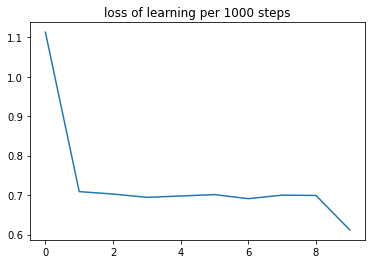

In [28]:
import matplotlib.pyplot as plt

plt.title('loss of learning per 1000 steps')
plt.plot(loss_arr)

202101544 마영준